
- final notebook will be imputing missing data from the dataset using regression models or seeing how these models work using data from another state
- Ultimate Test: using historical data from the LDH see if we can predict over time (this may be something that needs to be worked on after the independent study is complete unless it's relatively easy to to temporal modeling using the same methods)

https://www.youtube.com/watch?v=g9c66TUylZ4&t=789s # explanation of decision trees, how they are made

Starts with minimum SSR (sum of squred residuals at specific intervals (the averages between two points))

https://www.youtube.com/watch?app=desktop&v=c2XTNVdhX9E&feature=youtu.be obs

# Notebook 3

## Decision Trees (ISLR Chapter 8)

This dataset using US Census data from the 2019 ACS 5 year survey along with COVID-19 vaccination rate data from the Louisiana Department of Health. Data is organized by census tract. The first portion of this Notebook is include the data cleaning and manipulation code. For Imputing Missing Data teaching puropses, please start at [Filling in the Gaps](#start_here).

In [1]:
import os
import pandas as pd

In [2]:
dir_main = os.getcwd()

In [3]:
dir_data = os.path.join(dir_main, 'data')
dir_cleaning = os.path.join(dir_data, 'cleaning')

In [4]:
lst_names = os.listdir(dir_cleaning)
lst_names

lst_temp = []
for name in lst_names: # Filter system files out
    if not name.startswith('.'):
        lst_temp.append(name)
lst_names = lst_temp

In [5]:
lst_dfs = []
for name in lst_names:
    df_temp = pd.read_csv(os.path.join(dir_cleaning, name), header=None)
    
    df_temp.drop(df_temp.index[0], inplace=True) # Delete unneeded header
    new_header = df_temp.iloc[0] # Grab the first row for the header
    df_temp = df_temp[1:] # Take the data less the header row
    df_temp.columns = new_header # Set the header row as the df header
    
    lst_dfs.append(df_temp)

/Users/steele/opt/anaconda3/envs/ISLR/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,54

In [6]:
from functools import reduce

In [7]:
df_merged = reduce(lambda x, y: pd.merge(x, y, on='id'), lst_dfs) # Combine all dataframes together

In [8]:
df_stats = df_merged[['id',
                      'Labor Force Participation 16 and Older Percent',
                      'Median Household Income',
                      'Black Percent',
                      'No Vehicle Household Percent', 
                      'Population High School Graduate or Equivalency or Higher Percent']]

In [9]:
df_vac = pd.read_csv(os.path.join(dir_main, 'data', '2021.06.28_Vaccinations by Tract.csv'))

In [10]:
# Create column with percent vaccination series completed out of total population for census tract
df_vac['SeriesCompPercent'] = df_vac['SeriesComp']/df_vac['Total_2018Pop'] 

In [11]:
# Add full tract code to vaccination tracts
tracts = df_vac['TractID']
geoid = []
for tract in tracts:
    geoid.append('1400000US' + str(tract))
df_vac['id']  = geoid    

In [12]:
df_vac_orig = df_vac.copy(deep=True)

# Limit to only Orleans Parish
df_vac = df_vac[df_vac.parish == 'Orleans']

In [13]:
df_vac = df_vac[['id', 'Lat', 'Long', 'SeriesInt', 'SeriesComp', 'SeriesCompPercent']]

In [14]:
df = df_vac.merge(df_stats, on='id', copy=False)

### Changing Data Type
As shown below, we've got a mixture of datatypes. We'll need to change these to float in order to start creating models. 

In [15]:
df.dtypes

id                                                                   object
Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                       object
Median Household Income                                              object
Black Percent                                                        object
No Vehicle Household Percent                                         object
Population High School Graduate or Equivalency or Higher Percent     object
dtype: object

In [16]:
# The linear modeling will require int or float instead of objects,
# so we will convert the columns to numeric.
column_temp = df['id']
df.drop(columns='id', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') # Convert all columns to numeric
df['id'] = column_temp

df.dtypes

Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                      float64
Median Household Income                                             float64
Black Percent                                                       float64
No Vehicle Household Percent                                        float64
Population High School Graduate or Equivalency or Higher Percent    float64
id                                                                   object
dtype: object

In [17]:
df.describe()

Lat        Long    SeriesInt  SeriesComp  SeriesCompPercent  \
count  177.000000  177.000000   168.000000   168.00000         168.000000   
mean    29.971739  -90.057728  1096.696429  1002.87500           0.456262   
std      0.041055    0.056683   536.080081   488.38913           0.148525   
min     29.898550  -90.135307   214.000000   190.00000           0.075517   
25%     29.939842  -90.099388   746.250000   667.75000           0.346976   
50%     29.965729  -90.070679   995.000000   908.50000           0.431049   
75%     29.997370  -90.032219  1378.750000  1234.00000           0.576862   
max     30.121422  -89.752693  3972.000000  3309.00000           1.157398   

       Labor Force Participation 16 and Older Percent  \
count                                      174.000000   
mean                                        61.945402   
std                                         11.515823   
min                                          0.000000   
25%                                         55.150000   
50%                                         62.450000   
75%                                         70.475000   
max                                         83.700000   

       Median Household Income  Black Percent  No Vehicle Household Percent  \
count               170.000000     174.000000                    172.000000   
mean              48814.541176      56.397553                     20.184876   
std               31899.207159      32.718965                     14.593598   
min               10288.000000       0.901172                      0.000000   
25%               25073.000000      24.274568                      8.683670   
50%               39654.000000      67.377099                     17.044145   
75%               66384.250000      85.722305                     29.486389   
max              170278.000000      98.889755                     65.775401   

       Population High School Graduate or Equivalency or Higher Percent  
count                                         174.000000                 
mean                                           85.506897                 
std                                            10.522432                 
min                                            55.900000                 
25%                                            78.625000                 
50%                                            86.650000                 
75%                                            94.950000                 
max                                           100.000000

<a id='start_here'></a>
### Filling in the Gaps
<p>Sometimes we have missing data. In the dataset that we have been using for vaccination rates, census tracts with less than 1,000 people are not reported by the Louisiana Department of Health for privacy regions. We will be imputing missing data values based on the statistically significant predictor of race identified in previous notebooks.</p>

<p>The first step is to merge the census tract data with vaccine and social determinants of health data.</p>

In [18]:
import geopandas as gpd

In [19]:
gdf_tracts = gpd.read_file(os.path.join(dir_data, 'orl_census2010_tract_pl', 'orl_census2010_tract_pl.shp'))

In [20]:
df['id'] = df['id'].str[9:] # Drop unneeded portion of the census tract ID in order to merge

In [21]:
gdf = gdf_tracts.merge(df, how='left', left_on='GEOID10', right_on='id')

There's a lot of data we don't need, so we'll get rid of it.

In [22]:
gdf.columns.tolist()

['STATEFP10',
 'COUNTYFP10',
 'TRACTCE10',
 'GEOID10',
 'NAME10',
 'NAMELSAD10',
 'MTFCC10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'OID_',
 'GEOID10_1',
 'TOTAL_POP',
 'WHITE',
 'BLACK',
 'AMER_IND',
 'ASIAN',
 'PAC_ISLNDR',
 'OTHER_RACE',
 'MULTI_RACE',
 'HISPANIC',
 'NON_HISP',
 'TOTAL_HU',
 'OCC_HU',
 'VACANT_HU',
 'geometry',
 'Lat',
 'Long',
 'SeriesInt',
 'SeriesComp',
 'SeriesCompPercent',
 'Labor Force Participation 16 and Older Percent',
 'Median Household Income',
 'Black Percent',
 'No Vehicle Household Percent',
 'Population High School Graduate or Equivalency or Higher Percent',
 'id']

In [23]:
gdf_final = gdf[['id',
                 'Lat',
                 'Long',
                 'geometry',
                 'SeriesInt',
                 'SeriesComp',
                 'SeriesCompPercent',
                 'Labor Force Participation 16 and Older Percent',
                 'Median Household Income',
                 'Black Percent',
                 'No Vehicle Household Percent', 
                 'Population High School Graduate or Equivalency or Higher Percent']]

<p>Let's check for values that are not reported in the vaccination dataset.</p>

In [24]:
gdf_final['SeriesComp'].isnull().any()

True

In [25]:
# Find the number census tracts missing vaccination data
gdf_final['SeriesComp'].isnull().sum() 

9

<p>So, let's see which rows and map it out to check for ourselves.</p>

In [26]:
# Show the columns with missing vaccination data
gdf_final[gdf_final['SeriesInt'].isnull()] 

id        Lat       Long  \
5    22071980000  30.001497 -90.093094   
27   22071004402  29.965729 -90.077660   
31   22071000902  29.974344 -90.010941   
39   22071990000  30.121422 -89.972870   
50   22071001600  29.981749 -90.032219   
55   22071004800  29.959661 -90.073723   
83   22071000903  29.968637 -90.013290   
124  22071001751  30.030136 -89.910820   
170  22071980100  30.004488 -89.915703   

                                              geometry  SeriesInt  SeriesComp  \
5    POLYGON ((-90.08492 29.99661, -90.08492 29.996...        NaN         NaN   
27   POLYGON ((-90.07317 29.96439, -90.07303 29.964...        NaN         NaN   
31   POLYGON ((-90.00653 29.96960, -90.00670 29.969...        NaN         NaN   
39   POLYGON ((-89.98738 30.05384, -89.98747 30.053...        NaN         NaN   
50   POLYGON ((-90.02979 29.98250, -90.02963 29.982...        NaN         NaN   
55   POLYGON ((-90.07473 29.96220, -90.07435 29.961...        NaN         NaN   
83   POLYGON ((-90.00888 29.96468, -90.00894 29.964...        NaN         NaN   
124  POLYGON ((-90.02610 30.00535, -90.02697 30.008...        NaN         NaN   
170  POLYGON ((-89.85051 30.00774, -89.85774 30.007...        NaN         NaN   

     SeriesCompPercent  Labor Force Participation 16 and Older Percent  \
5                  NaN                                            50.0   
27                 NaN                                            42.6   
31                 NaN                                            63.4   
39                 NaN                                             NaN   
50                 NaN                                             NaN   
55                 NaN                                            73.6   
83                 NaN                                            53.9   
124                NaN                                            31.7   
170                NaN                                             NaN   

     Median Household Income  Black Percent  No Vehicle Household Percent  \
5                        NaN      20.000000                           NaN   
27                       NaN      85.416667                     65.775401   
31                   14271.0      92.900609                     42.767296   
39                       NaN            NaN                           NaN   
50                       NaN            NaN                           NaN   
55                   19681.0      96.915167                     39.240506   
83                   18879.0      98.533333                     20.945946   
124                  10288.0      80.827586                     56.721311   
170                      NaN            NaN                           NaN   

     Population High School Graduate or Equivalency or Higher Percent  
5                                                100.0                 
27                                                57.9                 
31                                                71.2                 
39                                                 NaN                 
50                                                 NaN                 
55                                                69.6                 
83                                                74.3                 
124                                               67.5                 
170                                                NaN

In [27]:
from statistics import mean

In [28]:
mean_lat = mean(gdf['Lat']) # Get the average of the latitude for map start location
mean_lat

29.971738553672317

In [29]:
import folium

In [30]:
# Initialize map
m = folium.Map(location=[mean_lat, -90],
               zoom_start=12,
               tiles=None)

# Add stamen toner basemap to make it look pretty
folium.raster_layers.TileLayer(tiles='Stamen Toner', 
                               min_zoom=0, max_zoom=18, 
                               max_native_zoom=None, attr=None, 
                               API_key=None, detect_retina=False, 
                               name=None, overlay=False, control=False, 
                               show=True, no_wrap=False, subdomains='abc', 
                               tms=False, opacity=0.3
                              ).add_to(m)

# Add choropleth layer with percentage of population that has been fully vaccinated
folium.Choropleth(geo_data=gdf_final,
                  name="Just Chekcing to See What's Missing",
                  data=gdf_final,
                  columns=['id','SeriesCompPercent'],
                  key_on='feature.properties.id').add_to(m)

# Add a mouseover to show details on census tracts and highlight
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#6f6f6f', 
                            'fillOpacity': 0, 
                            'weight': 0.1
                           }
highlight_function = lambda x: {#'fillColor': '#f3e20c',
                                'color':'white',
                                'fillOpacity': 0.0,
                                'weight': 5
                               }

popup = folium.features.GeoJson(
    gdf_final,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(fields=['id',
                                                   'SeriesCompPercent',
                                                   'Black Percent'],
                                           aliases=['Census Tract: ',
                                                    'Percent Fully Vaccinated of Total Population:',
                                                    'Percent Black Population: '                                                   ],
                                           style=("background-color: grey; color: #ffffff; font-family: arial; font-size: 12px; padding: 10px;")
                                          )
)
m.add_child(popup)
m.keep_in_front(popup)

In [31]:
m

<p>The circled census tracts below show areas that are missing vaccination data due to the fact that the Louisiana Department of Health does not release data on census tracts with less than 1,000 people due to privacy concerns. Other areas are missing data as well, but these are our primary concern as they are City Park and lake Pontchartrain.</p>
<p><i> Note: In the normal process of data cleaning we would find out why there is a census tract(s) with above 100% vaccination rate. However, we will ignore this issue for the purposes of this notebook.</i></p>

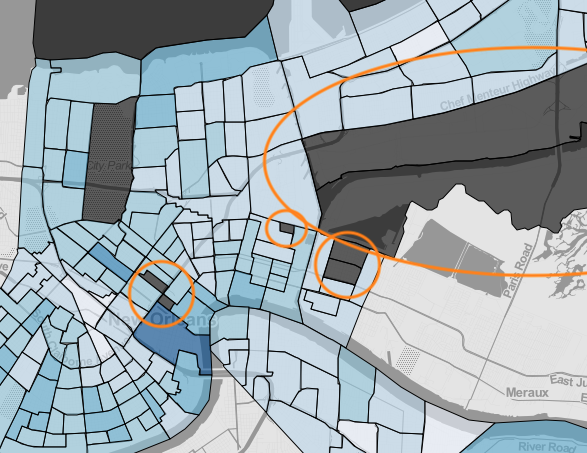

### Imputing Missing Data
<p>In previous notebooks we dropped rows missing vaccination data, but this time we will use inferential modeling to impute the missing data based on the statistically significant social determinant of health determined in previous notebooks.</p>

<p>Since we can't impute values which don't have a <code>Black Percent</code> value, we will drop these rows from the dataset.</p>

In [32]:
# Drop rows which are missing Black Percent values
gdf_clean = gdf_final.dropna(subset=['Black Percent'])

In [33]:
gdf_clean[gdf_clean['SeriesCompPercent'].isnull()] 

id        Lat       Long  \
5    22071980000  30.001497 -90.093094   
27   22071004402  29.965729 -90.077660   
31   22071000902  29.974344 -90.010941   
55   22071004800  29.959661 -90.073723   
83   22071000903  29.968637 -90.013290   
124  22071001751  30.030136 -89.910820   

                                              geometry  SeriesInt  SeriesComp  \
5    POLYGON ((-90.08492 29.99661, -90.08492 29.996...        NaN         NaN   
27   POLYGON ((-90.07317 29.96439, -90.07303 29.964...        NaN         NaN   
31   POLYGON ((-90.00653 29.96960, -90.00670 29.969...        NaN         NaN   
55   POLYGON ((-90.07473 29.96220, -90.07435 29.961...        NaN         NaN   
83   POLYGON ((-90.00888 29.96468, -90.00894 29.964...        NaN         NaN   
124  POLYGON ((-90.02610 30.00535, -90.02697 30.008...        NaN         NaN   

     SeriesCompPercent  Labor Force Participation 16 and Older Percent  \
5                  NaN                                            50.0   
27                 NaN                                            42.6   
31                 NaN                                            63.4   
55                 NaN                                            73.6   
83                 NaN                                            53.9   
124                NaN                                            31.7   

     Median Household Income  Black Percent  No Vehicle Household Percent  \
5                        NaN      20.000000                           NaN   
27                       NaN      85.416667                     65.775401   
31                   14271.0      92.900609                     42.767296   
55                   19681.0      96.915167                     39.240506   
83                   18879.0      98.533333                     20.945946   
124                  10288.0      80.827586                     56.721311   

     Population High School Graduate or Equivalency or Higher Percent  
5                                                100.0                 
27                                                57.9                 
31                                                71.2                 
55                                                69.6                 
83                                                74.3                 
124                                               67.5

In [34]:
df_impute_vals = gdf_clean[['SeriesCompPercent', 'Black Percent']]

<p>Looks like we have a total of 6 census tracts which we can attempt to impute missing values.</p> 

In [35]:
df_impute_vals[df_impute_vals['SeriesCompPercent'].isnull()]

SeriesCompPercent  Black Percent
5                  NaN      20.000000
27                 NaN      85.416667
31                 NaN      92.900609
55                 NaN      96.915167
83                 NaN      98.533333
124                NaN      80.827586

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [37]:
# Initialize the imputer
imp = IterativeImputer(max_iter=10, random_state=0)
# Fit the data on to the modeler
imp.fit(df_impute_vals)
# Impute new values
df_imputed = imp.transform(df_impute_vals)
# Convert output numpy array to pandas dataframe
df_imputed = pd.DataFrame(df_imputed, columns=df_impute_vals.columns)

In [38]:
# Check to see the values have been imputed
df_imputed

SeriesCompPercent  Black Percent
0             0.465859      73.225806
1             0.413501       4.995005
2             0.293058      77.569373
3             0.310372      88.154070
4             0.692377      14.297589
..                 ...            ...
169           0.436050      18.221393
170           0.474493      87.008086
171           0.497999      45.367412
172           0.319645      83.001049
173           0.418260      72.006539

[174 rows x 2 columns]

<p>Now we just need to combine the imputed values back into the original geodataframe and map.</p>

In [39]:
list_temp = df_imputed['SeriesCompPercent'].to_list()
gdf_clean['SeriesCompPercentImputed'] = list_temp
# We can ignore the warning as we will no longer be writing to any dataframes.

/Users/steele/opt/anaconda3/envs/ISLR/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [40]:
# Initialize map
m2 = folium.Map(location=[mean_lat, -90],
               zoom_start=12,
               tiles=None)

# Add stamen toner basemap to make it look pretty
folium.raster_layers.TileLayer(tiles='Stamen Toner', 
                               min_zoom=0, max_zoom=18, 
                               max_native_zoom=None, attr=None, 
                               API_key=None, detect_retina=False, 
                               name=None, overlay=False, control=False, 
                               show=True, no_wrap=False, subdomains='abc', 
                               tms=False, opacity=0.3
                              ).add_to(m2)

# Add choropleth layer with percentage of population that has been fully vaccinated including imputed values
folium.Choropleth(geo_data=gdf_clean,
                  name="New Map with Imputed Values",
                  data=gdf_clean,
                  columns=['id','SeriesCompPercentImputed'],
                  key_on='feature.properties.id').add_to(m2)

# Add a mouseover to show details on census tracts and highlight
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#6f6f6f', 
                            'fillOpacity': 0, 
                            'weight': 0.1
                           }
highlight_function = lambda x: {#'fillColor': '#f3e20c',
                                'color':'white',
                                'fillOpacity': 0.0,
                                'weight': 5
                               }

popup = folium.features.GeoJson(
    gdf_clean,
    style_function=style_function,
    control=False,
    highlight_function=highlight_function,
    tooltip=folium.features.GeoJsonTooltip(fields=['id',
                                                   'SeriesCompPercentImputed',
                                                   'Black Percent'],
                                           aliases=['Census Tract: ',
                                                    'Percent Fully Vaccinated of Total Population:',
                                                    'Percent Black Population: '                                                   ],
                                           style=("background-color: grey; color: #ffffff; font-family: arial; font-size: 12px; padding: 10px;")
                                          )
)
m2.add_child(popup)
m2.keep_in_front(popup)

In [41]:
m2

<p>All the ares we were attemping to impute vaccination rate data for were successfully imputed using the statistically significant predictor of race we found in previous notebooks. There are many different methods for imputing data along with different libraries for different use cases. One of the more common methods is the <a href="https://www.statsmodels.org/dev/generated/statsmodels.imputation.mice.MICE.html">statsmodels Multiple Imputation with Chained Equations (MICE)</a> which you may be familiar with in R and <a href="https://scikit-learn.org/stable/modules/impute.html">K Nearest Neighbors (KNN) in SciKitLearn</a>.</p>